## Analysing Schrodinger FEP+ results

In [37]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import kendalltau, pearsonr, spearmanr

### Obtain ddG values for each ligand pair/edge in the graph

In [38]:
path = "/biggin/t001/bioc1805/Git/fep-schrodinger/data"
systems = [name for name in os.listdir(
    path) if os.path.isdir(os.path.join(path, name))]

In [39]:
ddg_file = "/biggin/t001/bioc1805/Git/fep-schrodinger/ja512751q_si_003_ddG.csv"
ddg_data = pd.read_csv(ddg_file)
ddg_data["system"] = ddg_data["system"].str.upper()

In [40]:
sys_edge_data, rmse = {}, {}
exp_col = "exp_ddG"
comp_col = "ccc_ddG"
skip = []

for system in systems:

    if system in skip:
        continue

    sys_name = system.upper()
    edge_data = ddg_data[ddg_data['system'] == sys_name]
    sys_edge_data[system] = edge_data
    mse_pw = np.square(np.subtract(
        edge_data[exp_col], edge_data[comp_col])).mean()
    rmse_pw = np.sqrt(mse_pw)
    rmse[system] = rmse_pw
    print(f"{system} | No. edges: {len(edge_data)} | RMSE_pw: {rmse_pw:.2f}")

Jnk1 | No. edges: 31 | RMSE_pw: 1.00
Bace | No. edges: 58 | RMSE_pw: 1.03
p38 | No. edges: 56 | RMSE_pw: 1.03
PTP1B | No. edges: 49 | RMSE_pw: 1.22
MCL1 | No. edges: 71 | RMSE_pw: 1.41
Tyk2 | No. edges: 24 | RMSE_pw: 0.93
Thrombin | No. edges: 16 | RMSE_pw: 0.93
CDK2 | No. edges: 25 | RMSE_pw: 1.11


In [41]:
ddg_data.dropna(axis=1, inplace=True)
ddg_data.to_csv("../data/all_ligand_edges_ddg.csv", index=False, header=True)

### Visualise absolute predictions

In [17]:
dg_file = "/biggin/t001/bioc1805/Git/fep-schrodinger/ja512751q_si_003_dG.csv"
dg_data = pd.read_csv(dg_file)
dg_data["Systems"] = dg_data["Systems"].str.upper()

In [18]:
sys_pred_data, kts, prs, sprs = {}, {}, {}, {}
exp_col = "Exp. dG"
comp_col = "Pred. dG"
skip = []

for system in systems:

    if system in skip:
        continue

    sys_name = system.upper()
    pred_data = dg_data[dg_data['Systems'] == sys_name]
    sys_pred_data[system] = pred_data

    kt = kendalltau(pred_data[exp_col], pred_data[comp_col])
    kts[system] = kt

    pr = pearsonr(pred_data[exp_col], pred_data[comp_col])[0]
    prs[system] = pr

    spr = spearmanr(pred_data[exp_col], pred_data[comp_col])[0]
    sprs[system] = spr

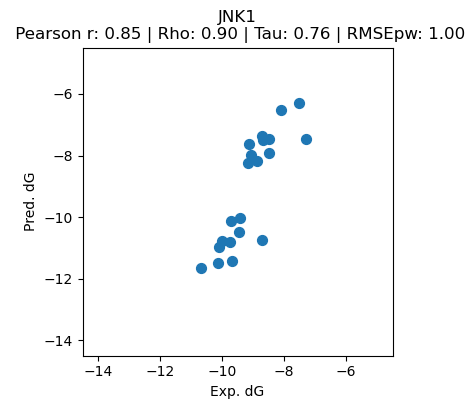

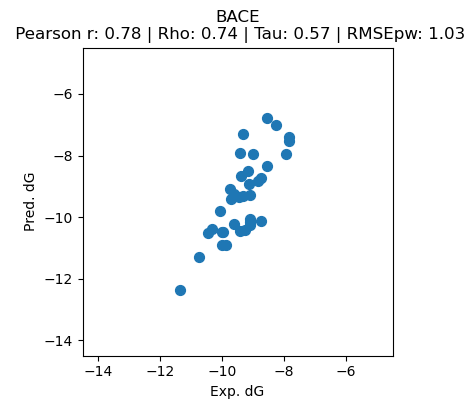

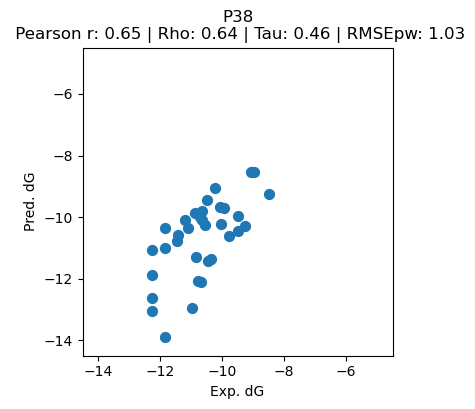

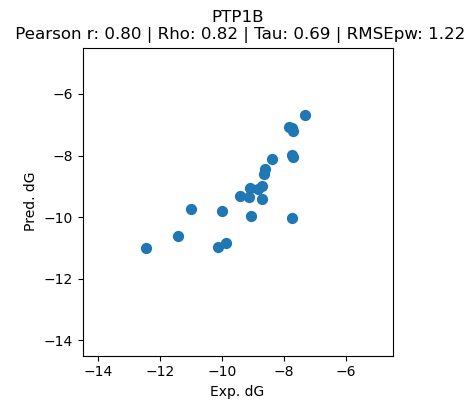

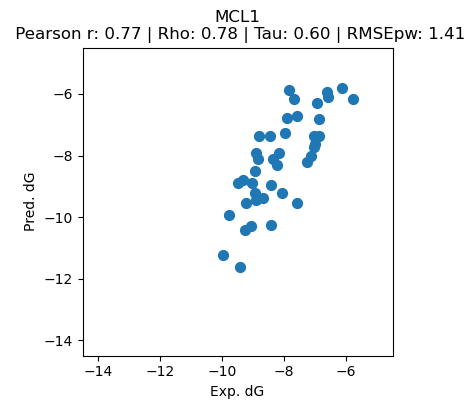

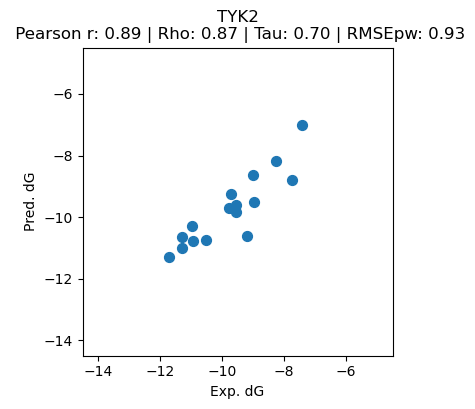

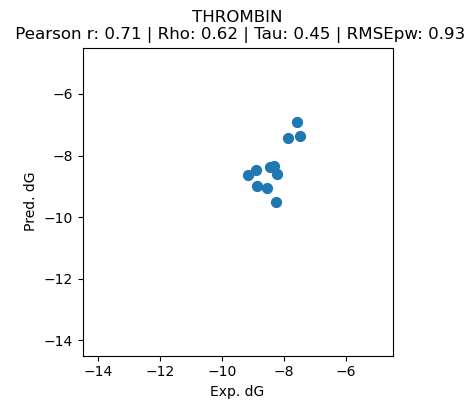

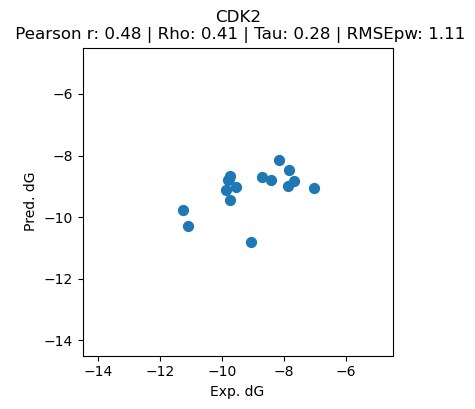

In [21]:
for system in systems:
    if system in skip:
        continue
    sys_pred_data[system].plot.scatter(
        x=exp_col,
        y=comp_col,
        figsize=(4, 4),
        s=50,
        xlim=(-14.5, -4.5),
        ylim=(-14.5, -4.5),
        title=f"{str.upper(system)}\n Pearson r: {prs[system]:.2f} | Rho: {sprs[system]:.2f} | Tau: {kts[system][0]:.2f} | RMSEpw: {rmse[system]:.2f}",
    )

### Ligand properties

In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import pickle
import pandas as pd

In [2]:
def compute_molecular_properties(mol, return_dict=False):
    """
    Compute molecular properties for a given RDKit molecule object (mol).
    
    Parameters:
    - mol: RDMol object
    
    Returns:
    A dictionary with the following keys:
    - 'MolecularWeight': Molecular weight of the molecule
    - 'NumHeavyAtoms': Number of heavy (non-hydrogen) atoms
    - 'NumRotatableBonds': Number of rotatable bonds
    - 'NumHDonors': Number of hydrogen bond donors
    - 'NumHAcceptors': Number of hydrogen bond acceptors
    - 'LogP': LogP value of the molecule
    """
    if return_dict:
        properties = {
            'MolecularWeight': Descriptors.MolWt(mol),
            'NumHeavyAtoms': Lipinski.HeavyAtomCount(mol),
            'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
            'NumHDonors': Lipinski.NumHDonors(mol),
            'NumHAcceptors': Lipinski.NumHAcceptors(mol),
            'LogP': Descriptors.MolLogP(mol),
            'Elements' : set([atom.GetSymbol() for atom in mol.GetAtoms()])
        }

        return properties

    else:
        return [Descriptors.MolWt(mol), Lipinski.HeavyAtomCount(mol), Descriptors.NumRotatableBonds(mol), Lipinski.NumHDonors(mol), Lipinski.NumHAcceptors(mol), Descriptors.MolLogP(mol), set([atom.GetSymbol() for atom in mol.GetAtoms()])]

In [3]:
ligand_mol_dict = pickle.load(open('../data/all_ligands_mol_dict.pkl', 'rb'))

In [4]:
target_properties_df = pd.DataFrame()

for target in ligand_mol_dict:

    target_properties = [0, 0, 0, 0, 0, 0]
    target_elements = set()

    for ligand in ligand_mol_dict[target]:
        properties = compute_molecular_properties(ligand_mol_dict[target][ligand]['rdmol'], return_dict=False)
        elements = properties[-1]
        properties = properties[:-1]

        target_properties = [sum(x) for x in zip(target_properties, properties)]
        target_elements = target_elements.union(elements)

    target_properties = [prop/len(ligand_mol_dict[target]) for prop in target_properties]
    target_properties.insert(0, target)
    target_properties.append(target_elements)

    target_properties_df = pd.concat([target_properties_df, pd.DataFrame(target_properties).T])

target_properties_df.columns = ['Target', 'MolecularWeight', 'NumHeavyAtoms', 'NumRotatableBonds', 'NumHDonors', 'NumHAcceptors', 'LogP', 'Elements']

target_properties_df.set_index('Target', inplace=True)
target_properties_df.to_csv('../data/ligand_properties.csv')


In [5]:
target_properties_df

,MolecularWeight,NumHeavyAtoms,NumRotatableBonds,NumHDonors,NumHAcceptors,LogP,Elements
Target,,,,,,,
Jnk1,364.762429,25.619048,9.857143,2.095238,6.52381,2.241861,"{N, O, Br, S, Cl, C, H}"
Bace,353.021694,25.694444,4.5,2.0,2.888889,1.188702,"{N, O, S, Cl, C, H, F}"
p38,406.507706,28.970588,6.588235,1.352941,7.529412,2.693761,"{N, O, S, Cl, C, H, F}"
PTP1B,484.729522,29.478261,8.26087,0.956522,7.782609,1.684175,"{N, O, Br, S, Cl, C, H, F}"
MCL1,364.160905,25.833333,6.880952,0.690476,3.404762,3.997448,"{N, O, S, Cl, C, H, F}"
Tyk2,359.364312,23.5,4.375,2.125,3.1875,4.071836,"{N, O, Cl, C, H, F}"
Thrombin,397.654273,27.363636,7.545455,2.0,2.0,1.756853,"{I, N, O, Br, Cl, C, H, F}"
CDK2,380.664312,26.875,6.8125,2.4375,6.25,3.661969,"{N, O, Br, S, Cl, C, H}"
